In [808]:
import numpy as np
from numpy import sin, cos,exp,pi
from itertools import product
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d
from scipy.ndimage import rotate
# import h5py
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import cv2
import re
import pandas as pd

In [2494]:
%run "C:\Users\gabri\Documents\NPGMI-Library\NPGMI Base Code.ipynb"

In [3]:
MONO_DATA = np.genfromtxt("mono_contrast_data.csv", delimiter = ",").T
MONO_ERROR = abs(MONO_DATA[1] - (np.genfromtxt("mono_error.csv", delimiter = ",").T)[1])
BI_DATA = np.genfromtxt("bichromatic_from_paper.csv", delimiter = ",").T
BI_ERROR = abs(BI_DATA[1] - (np.genfromtxt("bi_error_paper.csv", delimiter = ",").T)[1])
POLY_DATA = np.genfromtxt("polychromatic_from_paper.csv", delimiter = ",").T
POLY_ERROR = abs(POLY_DATA[1] - (np.genfromtxt("poly_error_paper.csv", delimiter = ",").T)[1])

### SEM Profile Processing (needs incorporation to PGMI class)

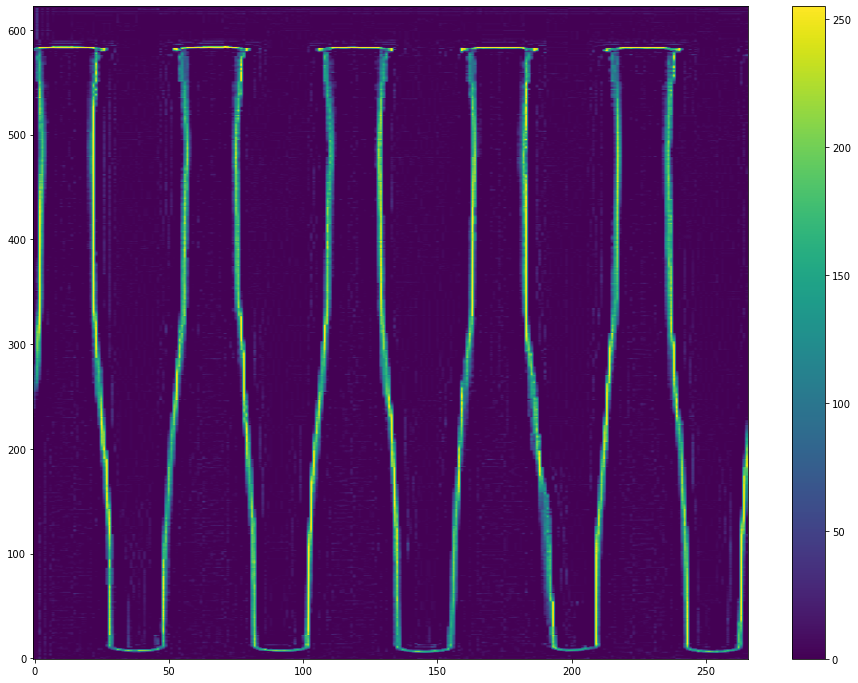

In [2214]:
batedgedetec = Image.open("baseballbatgratingSEM.jpg").filter(ImageFilter.FIND_EDGES)

batimg = np.array(batedgedetec)[:623,1:267,0]
batimg[570:610, 203:206] = 0
batimg[570:613, 253:256] = 0

cutoff = 90
batimg = batimg[::-1,...].T



fig,ax = plt.subplots(figsize = (16,12))
c = ax.imshow(batimg.T, aspect = "auto", origin = "lower")

fig.colorbar(c)
plt.show()
plt.close(fig)



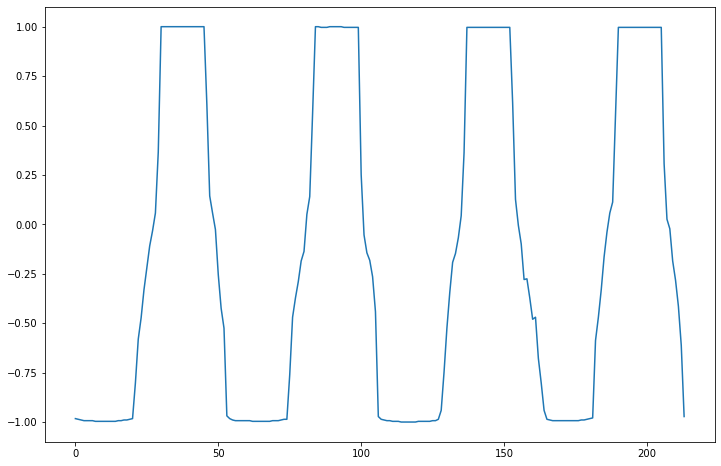

In [2251]:
ys = []
for i in range(batimg.shape[0]):
    for j in range(batimg.shape[1]):
        if batimg[i,j] > cutoff:
            ys.append(j)
            break

del ys[0]

oldbbprofile = np.array(ys[27:241])
            
oldbbprofile = 2* (oldbbprofile - np.min(oldbbprofile))/ (np.max(oldbbprofile) - np.min(oldbbprofile)) - 1
 
fig,ax = plt.subplots(figsize = (12,8))

ax.plot(oldbbprofile)
plt.show()
plt.close(fig)



9.599999999999918e-06


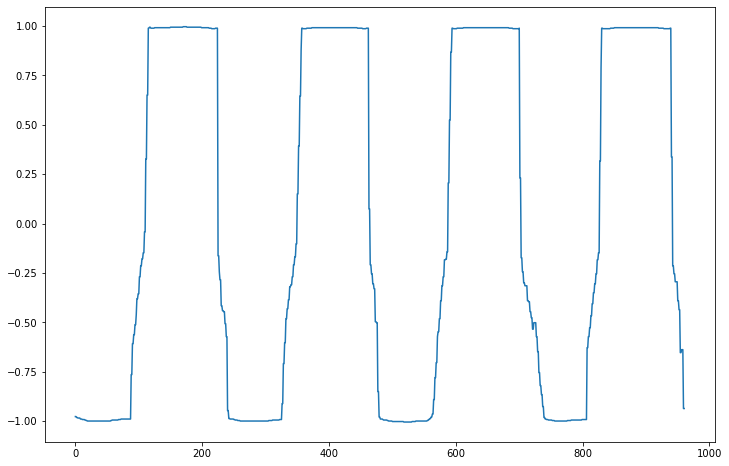

In [2252]:


bbx,bbprofile = np.genfromtxt("bbprofile.csv", delimiter= ",")[:-2].T
n_periods = 4
uniquex, uniqueind = np.unique(bbx,return_index = True)
bbprofile = bbprofile[uniqueind]
bbsize = max(uniquex) - min(uniquex)


print(bbsize)

fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(bbprofile,"-")

# [ax1.axvline(1.2e-6*i,color = "k") for i in range(9)]

plt.show()

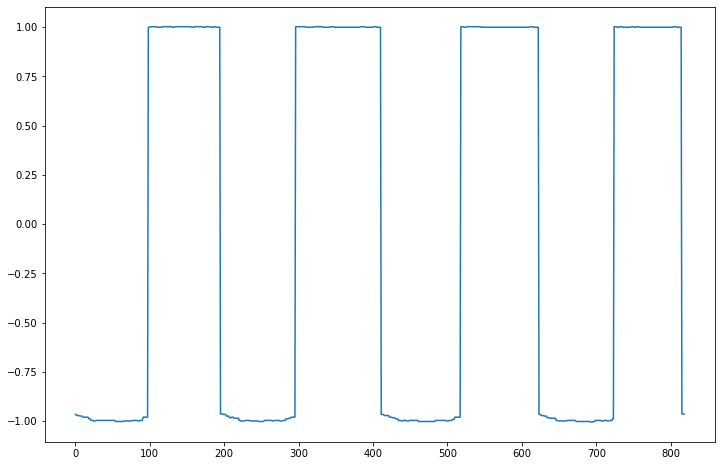

In [2254]:
def smooth_profile(profile, pct_diff):
    for i in range(1,len(profile)-1):
        a,b,c = profile[i-1], profile[i], profile[i+1]
        if abs((b - a)/b) > (pct_diff/100.0) and abs((b- c)/b) > (pct_diff/100.0):
            profile[i] = (a+c)/2
    return profile


rectangulargx, rectangularprofile = np.genfromtxt("rectprofile.csv", delimiter = ",")[:-1].T

runiquex, runiqueind = np.unique(rectangulargx,return_index=True)
rectangularprofile = rectangularprofile[runiqueind]


rsize = np.max(runiquex) - np.min(runiquex) 


rprofile = smooth_profile(rectangularprofile, 50)



fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(rprofile, "-")


# ax1.plot(runiquex,runiqueprofile, "-")

# [ax1.axvline(1.2e-6*i ,color = "k") for i in range(10)]
# fig.savefig("baserectprofile.jpg")
# [ax1.axvline(2.4e-6*i,color = "k") for i in range(5)]

plt.show()
plt.close(fig)

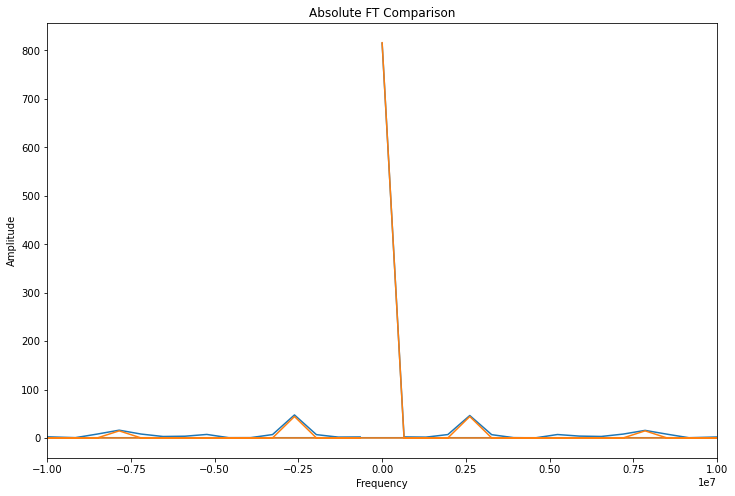

In [2483]:

fig,ax1 = plt.subplots(figsize=(12,8))
gix,gi = np.linspace(0,rsize,len(rprofile)), grating_equation(np.linspace(0,rsize,len(rprofile)),p,-413*pi/440)

# ax1.plot(runiquex*1e6, h2/2*rprofile, label = "Rectangular Grating SEM")
# ax1.plot(gix*1e6,h2/2 *gi, label = "Ideal G(x)")

# ax1.set_xlabel(r"X-axis $(\mu m)$")
# ax1.set_ylabel(r"Z-axis $(\mu m)$")
# ax1.set_title("Comparison on SEM Grating to Ideal G(x)")


fti,ftr = np.abs(fft(exp(1j*phi2[19]*gi))), np.abs(fft(exp(1j*phi2[19]*rprofile)))
freqsi, freqsr = get_freqs(fti,rsize), get_freqs(ftr,rsize)


ax1.plot(freqsr,ftr,label = "Rectangular Grating SEM")
ax1.plot(freqsi, fti,label = "Ideal G(x)")
plt.xlim(-1e7,1e7)

ax1.set_xlabel(r"Frequency")
ax1.set_ylabel(r"Amplitude")
ax1.set_title("Absolute FT Comparison")

# ax1.legend()
# fig.savefig("gratingFTcomparison.jpg")
plt.show()
plt.close(fig)

### Rotation Testing

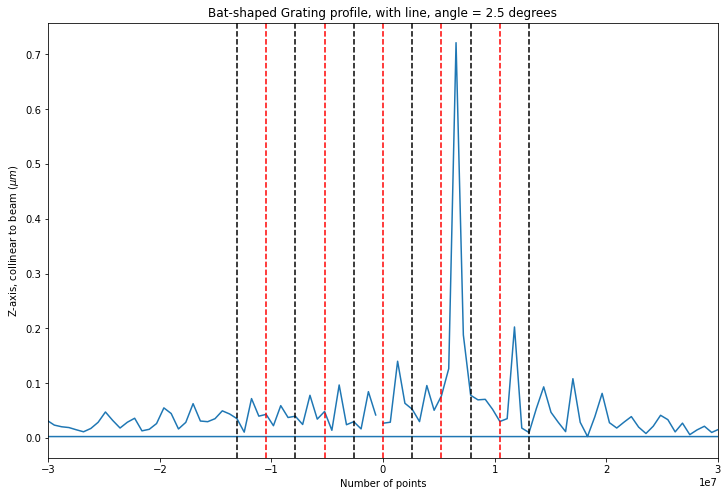

In [2115]:
fig,ax = plt.subplots(figsize = (12,8))

deg = 2.5


noline = h2*1e6/2 * bbprofile
lineadded = h2*1e6/2 * bbprofile + np.tan(np.radians(deg))*np.arange(len(bbprofile))

# ax.plot(noline)
# ax.plot(lineadded)

nolinefreqs, nolineft = rect_spectrum(np.arange(len(bbprofile)), bbsize, p,phi2[19],5,noline) 
withlinefreqs, withlineft = rect_spectrum(np.arange(len(lineadded)), bbsize, p,phi2[19],5,lineadded)

# ax.plot(nolinefreqs,abs(nolineft))
ax.plot(withlinefreqs,abs(withlineft))


ax.set_xlabel("Number of points")
ax.set_ylabel(r"Z-axis, collinear to beam $(\mu m)$")
ax.set_title("Bat-shaped Grating profile, with line, angle = %.1f degrees" % deg)

# plt.annotate(
#    '', xy=(130, h2*1e6/2), xycoords='data',
#    xytext=(130, -h2*1e6/2), textcoords='data',
#    arrowprops={'arrowstyle': '<->'})
# plt.annotate(
#    '$\it{h=29\mu m}$', xy=(-20, 0), xycoords='data',
#    xytext=(100,h2*1e6/2), textcoords='offset points')


# fig.savefig("batprofilewithline.jpg")

[ax.axvline(2*np.pi/p * m, color = "r" if m%2==0 else "k", ls = "--") for m in range(-5,6)]


plt.xlim(-3e7,3e7)

# fig.savefig("batprofilewithline.jpg")

plt.show()
plt.close(fig)

In [2284]:

t0 = time()

bbshape = bbprofile.shape[0]
heightinpts = round(bbshape/n_periods * 29e-6/(2.4e-6))

background = np.zeros((bbshape,heightinpts), dtype = np.int8)


bbscaled = (bbprofile - np.min(bbprofile) - 1/heightinpts) / (np.max(bbprofile) - np.min(bbprofile)) 

for col_ind, col in enumerate(background):
    background[col_ind,int(bbscaled[col_ind]*heightinpts)] = 1
    



deg = 1





rotated = rotate(background, -deg, axes = (0,1))



skew_mat = transforms.Affine2D().skew_deg(deg,0).get_matrix()[:2,:2]




skewed = np.zeros((rotated.shape[0],round(rotated.shape[1] * (np.cos(np.radians(deg)) + abs(np.sin(np.radians(deg)))))))

for i in range(rotated.shape[0]):
    for j in range(rotated.shape[1]):
        if rotated[i,j] > 0:
    
            new_ind = np.array([i,j]).dot(skew_mat).astype(int)
            
            skewed[new_ind[0],new_ind[1]] = rotated[i,j]

minheight = np.arange(skewed.shape[1])[np.argmax(np.sum(skewed[:,:skewed.shape[1]//4],axis = 0))]
maxheight = np.arange(skewed.shape[1])[np.argmax(np.sum(skewed[:,3*skewed.shape[1]//4:],axis = 0)) + 3*skewed.shape[1]//4]

print(time() - t0, "seconds")




4.620835542678833 seconds


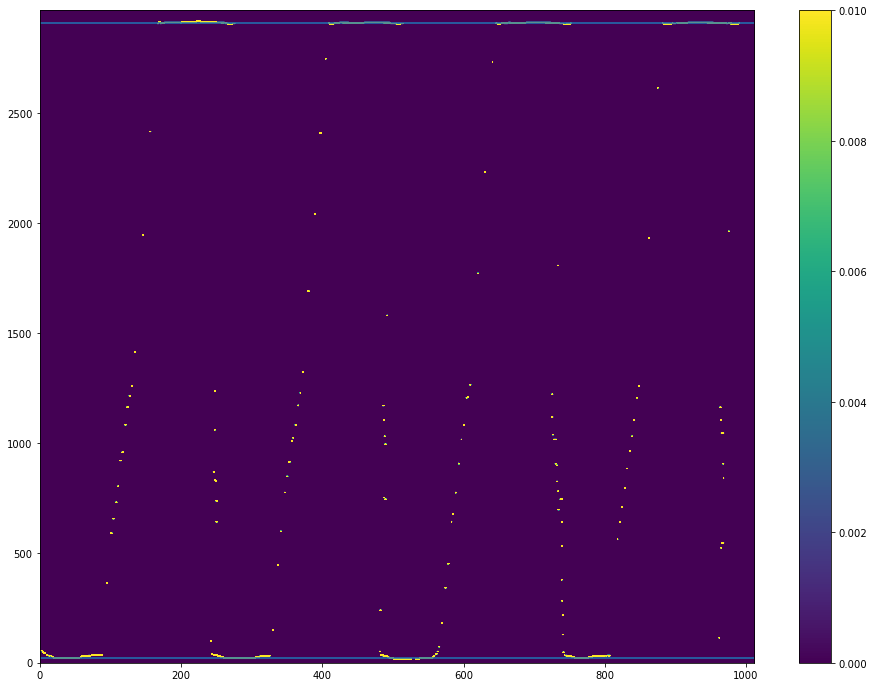

In [2285]:
fig,ax = plt.subplots(figsize = (16,12))
# ax.plot(bbscaled)
c = ax.imshow(skewed.T, aspect = "auto", origin = "lower",clim = (0,0.01))
fig.colorbar(c)


ax.axhline(minheight)
ax.axhline(maxheight)
plt.show()
plt.close(fig)

In [2286]:
minheight


22

In [2287]:
yskew = []

depth0 = skewed.shape[1] - 1
depth = 0



for i in range(skewed.shape[0]):
    for j in range(depth0,depth,-1):
        if skewed[i,j] > 0:
            yskew.append(j) 

#             if len(yskew) > 2:
#                 increasing = True if np.all(np.diff(yskew[-2:]) > 30) else False
            if j > minheight + 60 and j < maxheight - 100:
                depth = j 
            if abs(j - maxheight)/maxheight < 0.01:
                depth = 0
            
            
#             print(i,j,depth)
        
            break
            
            
            
            


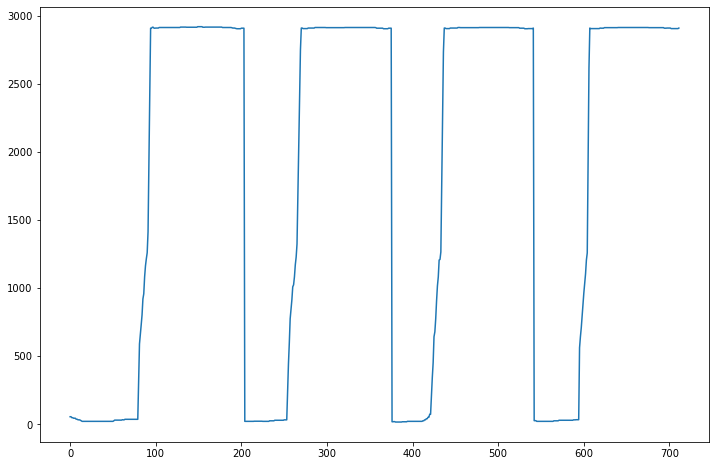

In [2347]:

yskew = np.array(smooth_profile(yskew,50))
rotatedbb = 2*(np.array(yskew) - min(yskew))/(max(yskew) - min(yskew)) - 1
# rotatedbb[70:80] = 1.


# rotatedsize = 

fig,ax = plt.subplots(figsize = (12,8))
ax.plot(yskew)

# ax.plot(rotatedbb[34:])
# ft = abs(fft(exp(phi2[19] * 1j * rotatedbb[34:])))
# freqs = get_freqs(ft,bbsize)

# ax.plot(freqs, ft/len(rotatedbb))

# plt.xlim(-3e7,3e7)

plt.show()

plt.close(fig)




### Testing to determine 2D Grating Profile

In [45]:
# phi = pi/2
# p = 3e-6

# x,y = np.linspace(0,5*p,1001), np.linspace(0,5*p,1001)

# z = rect_spectrum2d(x,x[-1],y,y[-1],p,p,phi,5)

# # z = phi/2 * (np.sign(np.cos(2*pi*x[:,None]/p).round(10)) + np.sign(np.cos(2*pi*y[None,:]/p).round(10)) )
# # z[z < 0 ] = 0


# fig, ax1 = plt.subplots(figsize = (12,12))
# # c = ax1.imshow(z, aspect = "auto", extent = (x[0],x[-1],y[0],y[-1]))
# # c = ax1.imshow(abs(fftshift(fft2(exp(1j*z)))), aspect = "auto")
# ax1.imshow(z, origin = "lower")
# # fig.colorbar(c)

# # plt.xlim(0,50)
# # plt.ylim(0,50)
# # fig.savefig("fft2.jpg")

# plt.show()

### 2PGMI PhysRevA


In [2407]:
p = 2.4e-6
L1 = 1.2
# L1 = 1.73
# L1 = 4.65

L0mono = -0.05
# L0bi = 0.01
# L0poly = 0.44
L = 2.99 - L0mono
# L = 3.52 - L0bi
# L = 8.8 - L0poly


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lam = np.array([4.4e-10])
plam = np.array([1])

# lam = np.array([4.4e-10,2.2e-10])
# plam = np.array([3.2/4.2,1/4.2])

# lam, plam = polyspectrum.copy()




mt = 5
x0 = np.array([0])

Nbc = 5e28*4.149e-15
h = 0.27*pi / (Nbc*4.4e-10)
# h = 0.2*pi / (Nbc*5e-10)

phi = Nbc*lam*h

camsize = 2.5e-2
slitx = 235e-6
# slitx = 550e-6

slity = 100e-6
xbin = 1e-6
ybin = 1e-6
res = 100e-6
# res = 150e-6


G1sd = {"p":p, "L1": np.array([L1]), "phi":phi}
G1sd["L2"] = np.linspace(3,19,51)*1e-3






G2sd = {"p":p, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi}
G2sd["L2"] = L - (G1sd["L1"] + G1sd["L2"])


# Ioff = np.linspace(-5000,5000,10)
simapts = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}
siminit = {"lam":lam, "plam": plam, "L":L,"d":G1sd["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "res": res, "batches" : 5000}


### 3PGMI PRL

In [2504]:

p = 2.4e-6
L = 8.8

# lam = np.array([5e-10])
# plam = np.array([1])

polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9


lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 5


Nbc = 5e28*4.149e-15
h1,h2,h3 = 15.8e-6,29e-6,15.8e-6

phi1,phi2,phi3 = Nbc*lam*h1,Nbc*lam*h2,Nbc*lam*h3
idealgrating_phase_offset = -413*pi/440


camsize = 2.5e-2
slitx = 500e-6
slity = 100e-6

xbin = 1e-6
ybin = 25e-6

res = 150e-6
d1 = 4.6e-2
L1 = 4.75

G1sd = {"p":p, "L1": np.array([L1-d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
G1sd["L2"] = np.array([d1])

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}


G2sd["L2"] = np.linspace(2,7,81)*1e-2 

# G2sd["L2"][G2sd["L2"] == d1] = d1 + 5e-5

G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
G3sd["L2"] = np.array([L]) - G3sd["L1"] 

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}


simaptsrect = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(np.empty_like(rprofile),G2sd,rsize,rprofile),\
           "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}


simaptsoldbb = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(np.empty_like(oldbbprofile),G2sd,bbsize,oldbbprofile),\
           "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}

simaptsbb = {"G1":GratingFromImage(np.empty_like(rprofile),G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(np.empty_like(bbprofile),G2sd,bbsize,bbprofile),\
           "G3":GratingFromImage(np.empty_like(rprofile),G3sd,rsize, rprofile)}







siminit = {"lam":lam, "plam":plam, "L":L,"d":G2sd["L2"]-d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 12500  }

In [275]:
# rphi2, rp = force_broadcast(phi2,rectangularprofile)
# bbphi2, bbp = force_broadcast(phi2,bbprofile)

# kgrect,agrect = rect_spectrum(np.empty_like(rp),rectangularsize - size_offset,p,rphi2,mt,rp)
# kgbb,agbb = rect_spectrum(np.empty_like(bbp),bbsize,p,bbphi2,mt,bbp)

# fig, (ax1,ax2) = plt.subplots(1,2,figsize  = (12,8))

# ax1.plot(lam,kgrect[...,1], label = "Rectangular Grating")

# ax1.plot(lam,kgbb[...,1], label = "Bat-shaped Grating")

# # ax2.plot(lam,np.real(agrect[...,2]), label = "Rectangular Grating, Real Part")

# # ax2.plot(lam,np.imag(agrect[...,2]), label = "Rectangular Grating, Imaginary Part")


# # ax2.plot(lam,np.real(agbb[...,2]), label = "Bat-shaped Grating, Real Part")


# # ax2.plot(lam,np.imag(agbb[...,2]), label = "Bat-shaped Grating, Imaginary Part")

# ax2.plot(lam,abs(agrect[...,1]), label = "Rectangular Grating, Magnitude")

# ax2.plot(lam,abs(agbb[...,1]), label = "Bat-shaped Grating, Magnitude")




# ax1.set_title("kg, 0th diffraction order")
# ax1.set_xlabel("Lambda")
# ax1.set_ylabel("Frequency")

# ax2.set_title("ag, 0th diffraction order")
# ax2.set_xlabel("Lambda")
# ax2.set_ylabel("Amplitude")

# ax1.legend()
# ax2.legend()

# # fig.savefig("absag0thvslambdarectandbat.jpg")
# plt.show()
# plt.close(fig)


In [2408]:

# t0 = time()
# simtest = PGMI(simapts,siminit)
# simtest.propagate_to("G1")
# simtest.propagate_to("G2")
# simtest.generate_after("G2")
# # simtest.propagate_to("G3")
# # simtest.generate_after("G3")


# print(time() - t0, "seconds")


0.000235
(5000, 51, 5) after parallel
(51, 25000) after reshape
(51, 25000) before convolution
Finding contrast
15.575159311294556 seconds


0.0005


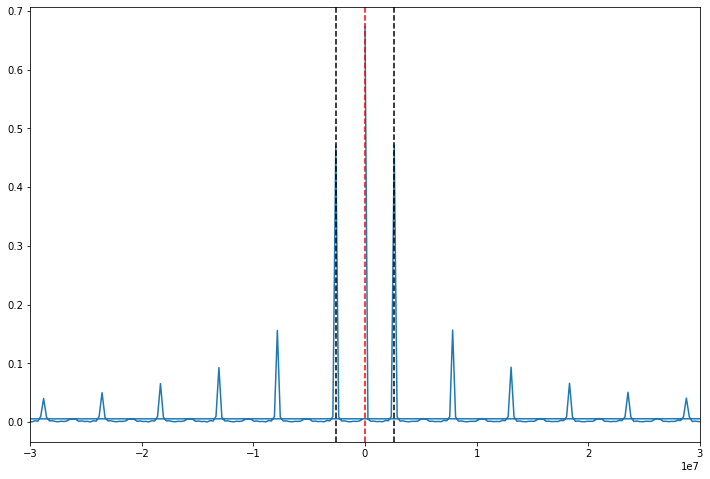

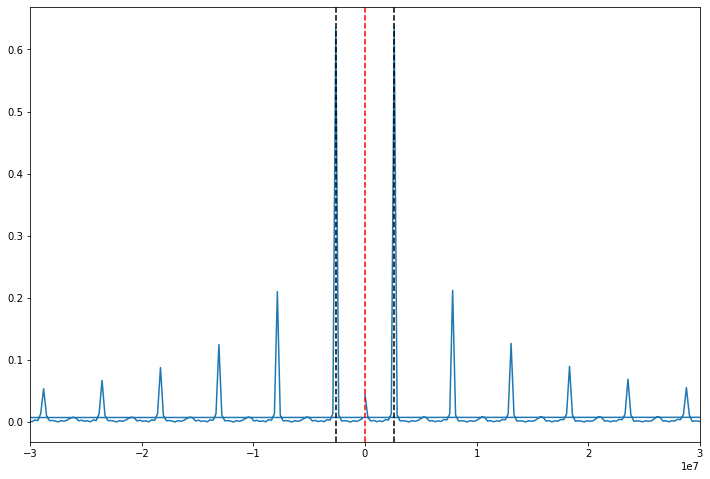

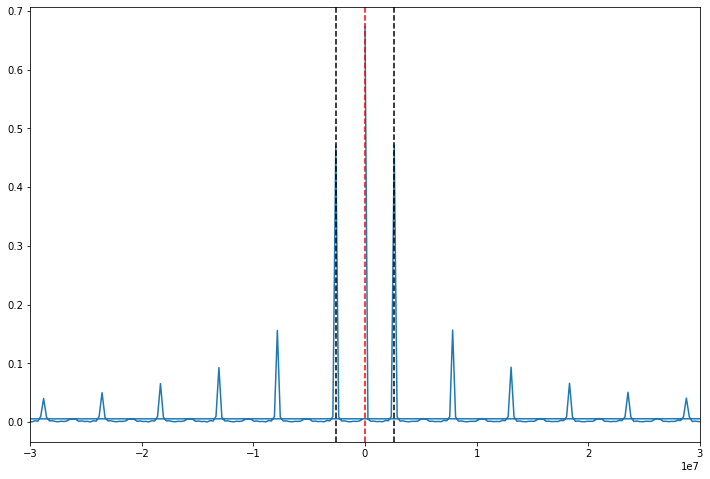

(12500, 81, 41, 2) after parallel
(81, 41, 25000) after reshape
(81, 25000) before convolution
Finding contrast
0.0005


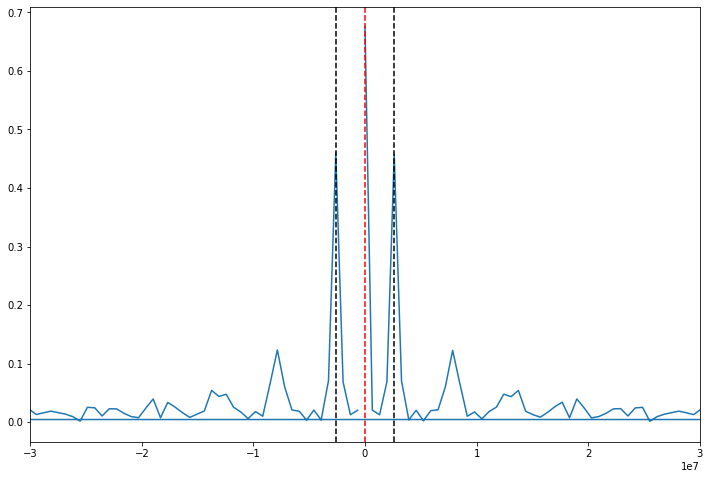

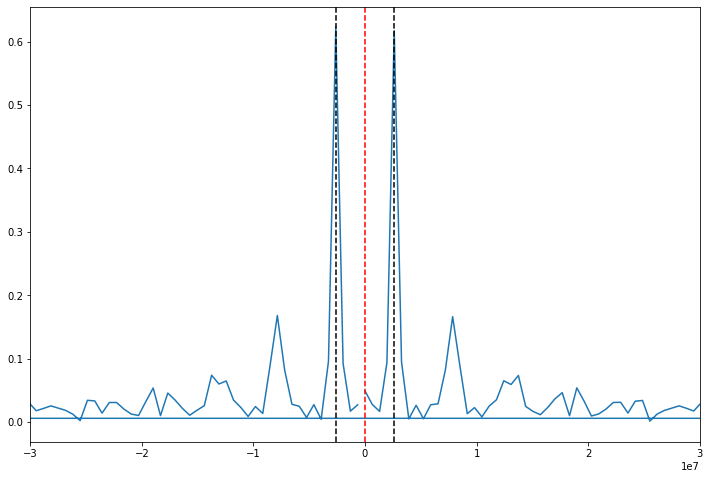

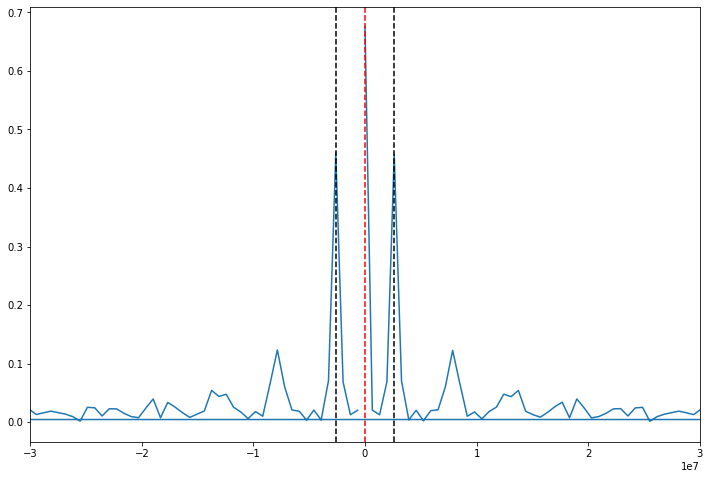

(12500, 81, 41, 2) after parallel
(81, 41, 25000) after reshape
(81, 25000) before convolution
Finding contrast
0.0005


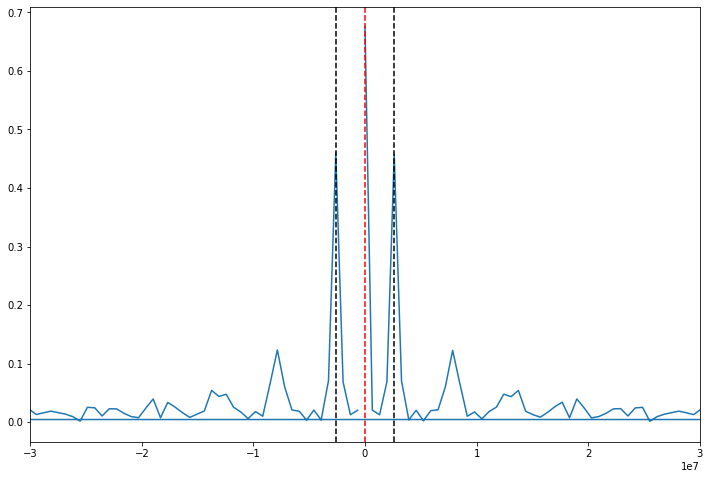

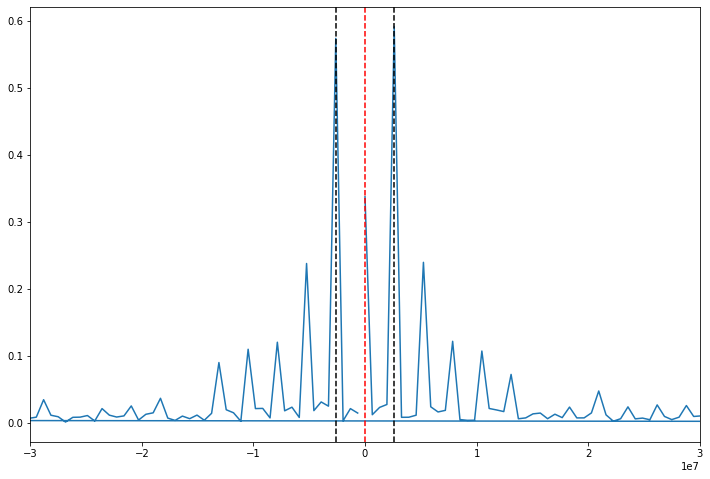

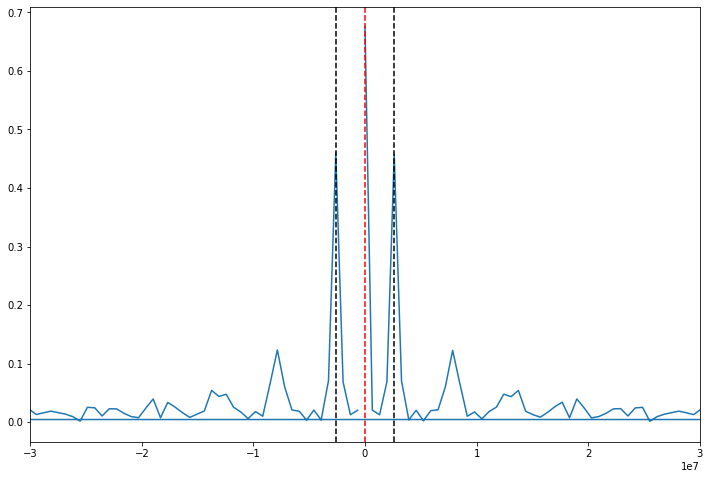

(12500, 81, 41, 2) after parallel
(81, 41, 25000) after reshape
(81, 25000) before convolution
Finding contrast
0.0005


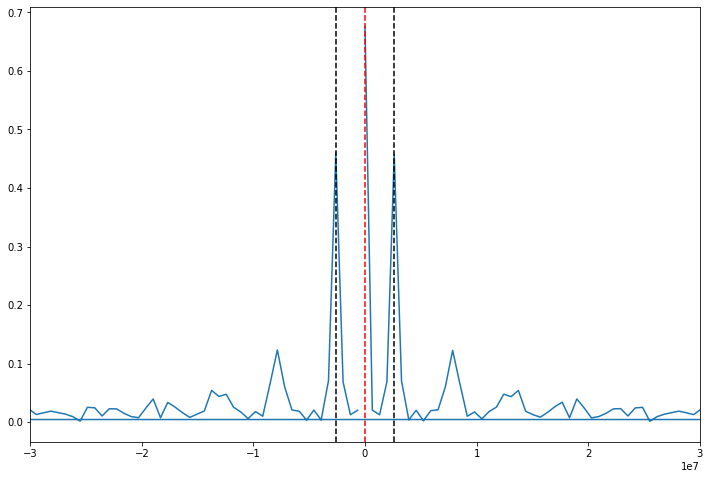

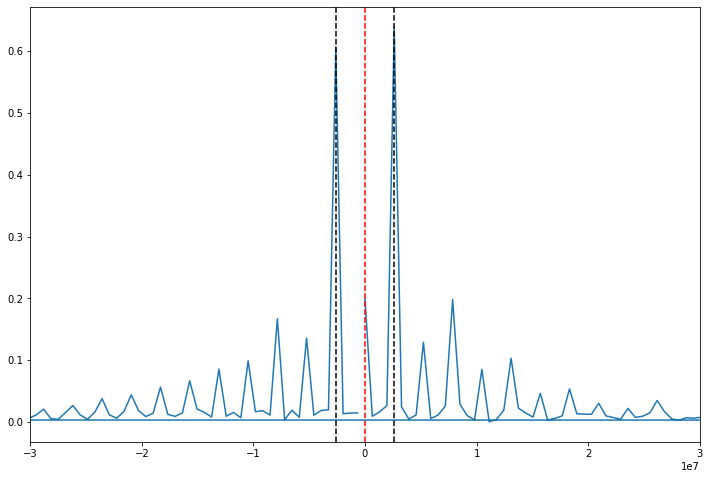

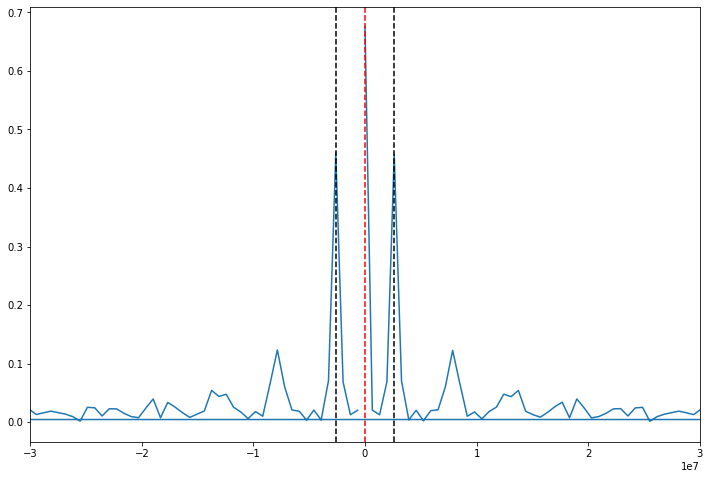

(12500, 81, 41, 2) after parallel
(81, 41, 25000) after reshape
(81, 25000) before convolution
Finding contrast
466.0503935813904 seconds


In [2496]:
t0 = time()

simideal = PGMI(simaptsideal,siminit)
simideal.propagate_to("G1")
simideal.propagate_to("G2")
simideal.propagate_to("G3")
simideal.generate_after("G3")


simrect = PGMI(simaptsrect,siminit)
simrect.propagate_to("G1")
simrect.propagate_to("G2")
simrect.propagate_to("G3")
simrect.generate_after("G3")

simoldbb = PGMI(simaptsoldbb,siminit)
simoldbb.propagate_to("G1")
simoldbb.propagate_to("G2")
simoldbb.propagate_to("G3")
simoldbb.generate_after("G3")


simbb = PGMI(simaptsbb,siminit)
simbb.propagate_to("G1")
simbb.propagate_to("G2")
simbb.propagate_to("G3")
simbb.generate_after("G3")

print(time() - t0, "seconds")


In [2409]:
monocont = simtest.get_value("contrast")
# bicont = simtest.get_value("contrast")
# polycont = simtest.get_value("contrast")

monofitparams = simtest.get_value("fitparams")
# bifitparams = simtest.get_value("fitparams")
# polyfitparams = simtest.get_value("fitparams")

In [2497]:
I3ideal = simideal.get_value("intensity")
cont3ideal = simideal.get_value("contrast")
fitparams3ideal = simideal.get_value("fitparams")



I3rect = simrect.get_value("intensity")
cont3rect = simrect.get_value("contrast")
fitparams3rect = simrect.get_value("fitparams")



I3oldbb = simoldbb.get_value("intensity")
cont3oldbb = simoldbb.get_value("contrast")
fitparams3oldbb = simoldbb.get_value("fitparams")

I3bb = simbb.get_value("intensity")
cont3bb = simbb.get_value("contrast")
fitparams3bb = simbb.get_value("fitparams")




# I3ideal5 = simideal.get_value("intensity")
# cont3ideal5 = simideal.get_value("contrast")
# fitparams3ideal5 = simideal.get_value("fitparams")



# I3rect5 = simrect.get_value("intensity")
# cont3rect5 = simrect.get_value("contrast")
# fitparams3rect5 = simrect.get_value("fitparams")



# I3oldbb5 = simoldbb.get_value("intensity")
# cont3oldbb5 = simoldbb.get_value("contrast")
# fitparams3oldbb5 = simoldbb.get_value("fitparams")

# I3bb5 = simbb.get_value("intensity")
# cont3bb5 = simbb.get_value("contrast")
# fitparams3bb5 = simbb.get_value("fitparams")



### 2PGMI Plots

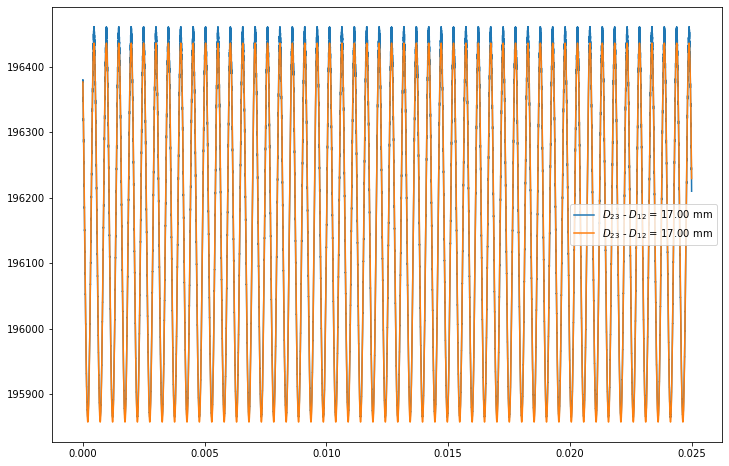

<AxesSubplot:>

In [66]:
# ax1.plot(Igeneral[10])
# ind = 26
for ind in range(Igeneral.shape[0]):
    fig, ax1 = plt.subplots(figsize  = (12,8))

    clear_output(wait= True)
    ax1.plot(simtest.x,Igeneral[ind], label = "$D_{23}$ - $D_{12}$ = %.2f mm" % (simtest.d[ind]*1e3))
    ax1.plot(simtest.x,cosine_func(simtest.x, *fitparams[ind]), label = "$D_{23}$ - $D_{12}$ = %.2f mm" % (simtest.d[ind]*1e3))
    ax1.legend()
    plt.pause(0.5)
    ax1.cla()
    plt.show()



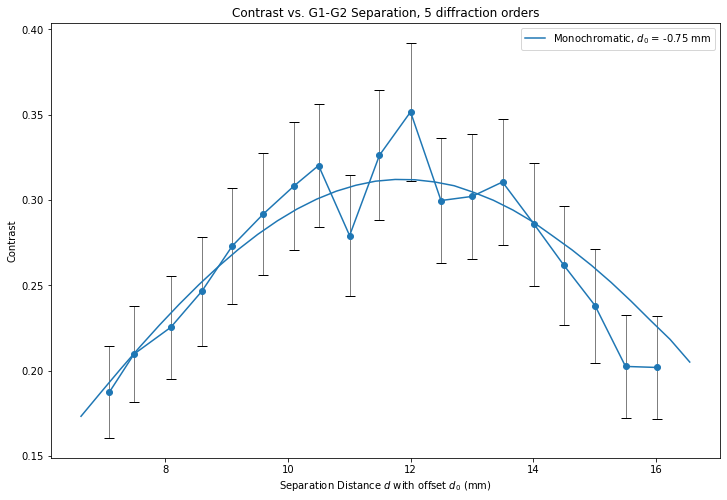

In [2410]:
fig, ax1 = plt.subplots(figsize  = (12,8))

d0 = {"mono": -0.75e-3, "bi": 0.8e-3, "poly": -0.38e-3}


ax1.plot((simtest.d[9:-10]-d0["mono"])*1e3, monocont[9:-10],label = r"Monochromatic, $d_0$ = %.2f mm" % (d0["mono"] * 1e3))

# ax1.plot((simtest.d[9:-10]-d0["bi"])*1e3, bicont[9:-10],label = r"Bichromatic, $d_0$ = %.2f mm" % (d0["bi"] * 1e3))

# ax1.plot((simtest.d-d0["poly"] )*1e3, polycont,label = r"Polychromatic, $d_0$ = %.2f mm" % (d0["poly"] * 1e3))


plt.gca().set_prop_cycle(None)

ax1.errorbar(MONO_DATA[0],MONO_DATA[1],MONO_ERROR, fmt = "-o",ecolor = "black", elinewidth = 0.5,capsize = 5)
# ax1.errorbar(BI_DATA[0]*1e3,BI_DATA[1],BI_ERROR, fmt = "-o",ecolor = "black", elinewidth = 0.5,capsize = 5)
# ax1.errorbar(POLY_DATA[0]*1e3,POLY_DATA[1],POLY_ERROR, fmt = "-o",ecolor = "black", elinewidth = 0.5,capsize = 5)

# ax1.axvline((p**2/5e-10)* 1e3, label = "Predicted max")





ax1.legend()

ax1.set_xlabel("Separation Distance $d$ with offset $d_0$ (mm)")
ax1.set_ylabel("Contrast")
ax1.set_title("Contrast vs. G1-G2 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
# fig.savefig("ContrastVsDwithchanges.jpg")
# ax1.set_xlim(0.55,9)
# plt.grid()
plt.show()

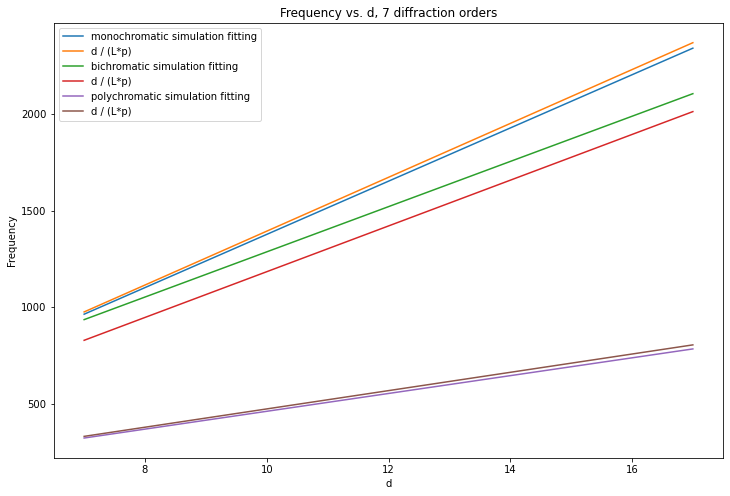

In [84]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(simtest.d*1e3, 1/monofitparams[:,2], label = "monochromatic simulation fitting")
ax1.plot(simtest.d*1e3, simtest.d/(2.99*2.4e-6), label = "d / (L*p)")

ax1.plot(simtest.d*1e3, 1/bifitparams[:,2], label = "bichromatic simulation fitting")
ax1.plot(simtest.d*1e3, simtest.d/(3.52*2.4e-6), label = "d / (L*p)")

ax1.plot(simtest.d*1e3, 1/polyfitparams[:,2], label = "polychromatic simulation fitting")
ax1.plot(simtest.d*1e3, simtest.d/(8.8*2.4e-6), label = "d / (L*p)")


ax1.legend()

ax1.set_xlabel("d")
ax1.set_ylabel("Frequency")
ax1.set_title("Frequency vs. d, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
plt.show()

### 3PGMI Plots

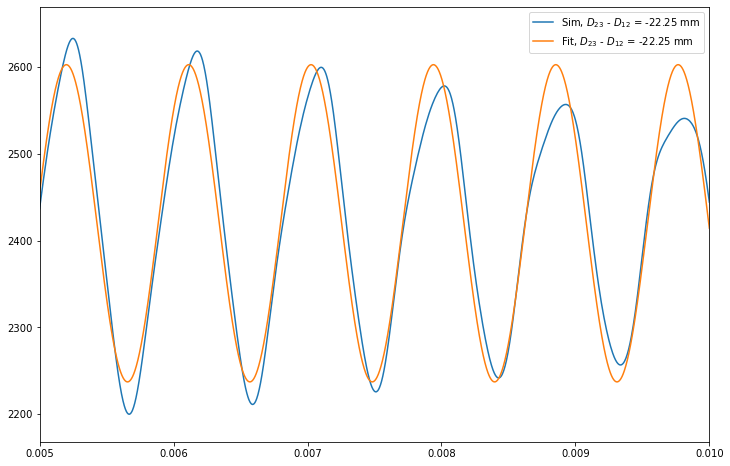

KeyboardInterrupt: 

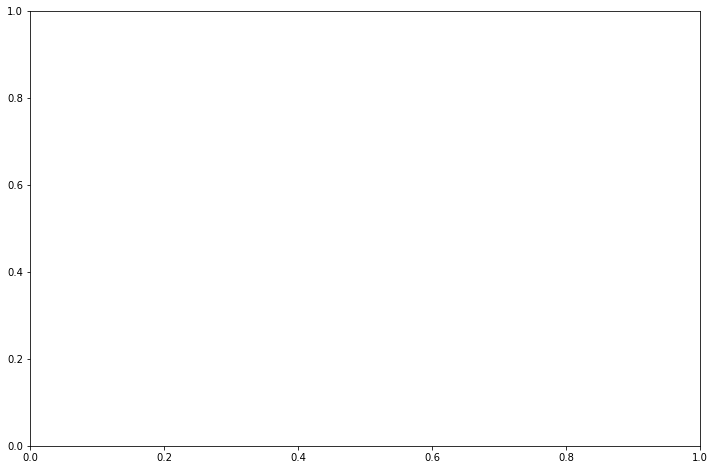

In [2369]:
theorycurves = []


for ind in range(I3bb.shape[0]):
    fig, ax1 = plt.subplots(figsize  = (12,8))
    clear_output(wait= True)
#     theorycurve = cosine_func(simbb.x, np.mean(I3bb[ind]), np.amax(I3bb[ind]) - np.mean(I3bb[ind]),\
#                                            L*p/simbb.d[ind],0)
    ax1.plot(simbb.x,I3bb[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3))
    ax1.plot(simbb.x,cosine_func(simbb.x, *fitparams3bb[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3))
#     ax1.plot(simbb.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3) )
#     theorycurves.append(theorycurve)
    ax1.legend()
    ax1.set_xlim(5e-3,10e-3)
    ax1.set_ylim()

    plt.pause(0.01)
#     ax1.cla()
    plt.show()
    plt.close(fig)
    
    

    
# for ind in range(I3ideal5.shape[0])[3:]:
#     fig, ax1 = plt.subplots(figsize  = (12,8))
#     clear_output(wait= True)
# #     theorycurve = cosine_func(simideal5.x, np.mean(I3ideal5[ind]), np.amax(I3ideal5[ind]) - np.mean(I3ideal5[ind]),\
# #                                            L*p/simideal5.d[ind],0)
#     ax1.plot(simideal.x,I3ideal5[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % (simideal.d[ind]*1e3))
#     ax1.plot(simideal.x,cosine_func(simideal.x, *fitparams3ideal5[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % (simideal.d[ind]*1e3))
# #     ax1.plot(simideal5.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simideal5.d[ind]*1e3) )
# #     theorycurves.append(theorycurve)
#     ax1.legend()
    
#     plt.pause(0.01)
# #     ax1.cla()

#     plt.show()
#     plt.close(fig)

In [2325]:
print(np.array(theorycurves).shape)
# cont3theory = maxmincont(np.array(theorycurves))


(0,)


In [2501]:
cont3bb[41] = 0
# cont3ideal5[41] = 0
# cont3rect5[41] = 0

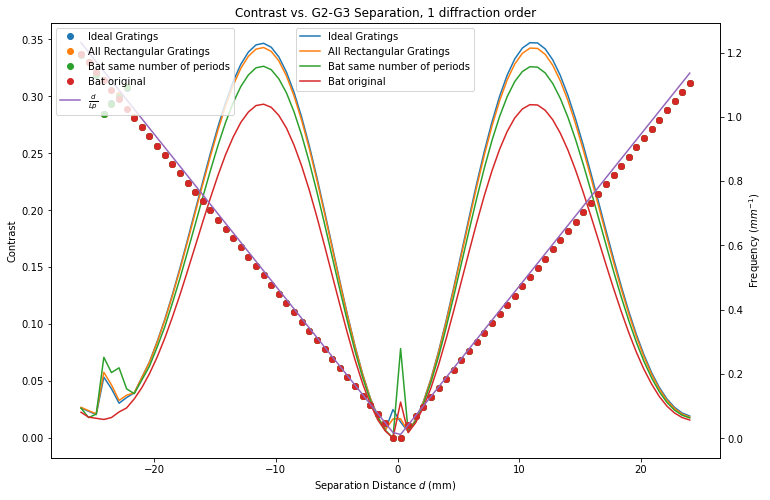

In [2503]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(simideal.d*1e3, cont3ideal, label = "Ideal Gratings")

ax1.plot(simrect.d*1e3, cont3rect, label = "All Rectangular Gratings")


ax1.plot(simbb.d*1e3, cont3bb, label = "Bat same number of periods")

ax1.plot(simbb.d*1e3, cont3oldbb, label = "Bat original")



# ax1.plot(simideal.d*1e3, cont3ideal5, label = "Ideal Gratings")


# ax1.plot(simrect.d*1e3, cont3rect5, label = "All Rectangular Gratings")


# ax1.plot(simbb.d*1e3, cont3bb5, label = "Bat same number of periods")

# ax1.plot(simbb.d*1e3, cont3oldbb5, label = "Bat original")



# ax1.plot(simideal.d*1e3, maxmincont(I3ideal5), label = "Ideal Gratings")


# ax1.plot(simrect.d*1e3, maxmincont(I3rect5), label = "All Rectangular Gratings")


# ax1.plot(simbb.d*1e3, maxmincont(I3bb5), label = "Bat same number of periods")

# ax1.plot(simbb.d*1e3, maxmincont(I3oldbb5), label = "Bat original")








# ax1.axvline(12)

ax2 = ax1.twinx()
ax2.plot(simideal.d*1e3, abs(1/fitparams3ideal[:,2]) / (1000), "o", label = "Ideal Gratings")

ax2.plot(simrect.d*1e3, abs(1/fitparams3rect[:,2]) / (1000), "o", label = "All Rectangular Gratings")



ax2.plot(simbb.d*1e3, abs(1/fitparams3bb[:,2]) / (1000), "o", label = "Bat same number of periods")

ax2.plot(simbb.d*1e3, abs(1/fitparams3oldbb[:,2]) / (1000), "o", label = "Bat original")



# ax2.plot(simideal.d*1e3, abs(1/fitparams3ideal5[:,2]) / (1000), "o", label = "Ideal Gratings")

# ax2.plot(simrect.d*1e3, abs(1/fitparams3rect5[:,2]) / (1000), "o", label = "All Rectangular Gratings")



# ax2.plot(simbb.d*1e3, abs(1/fitparams3bb5[:,2]) / (1000), "o", label = "Bat same number of periods")

# ax2.plot(simbb.d*1e3, abs(1/fitparams3oldbb5[:,2]) / (1000), "o", label = "Bat original")








ax2.plot(simbb.d*1e3, abs(simbb.d / (L*p*1e3)), label = r"$\frac{d}{Lp}$")

ax1.legend(loc = "upper center", prop = {"size":10})
ax2.legend(loc = "upper left", prop = {"size":10})

ax1.set_xlabel("Separation Distance $d$ (mm)")
ax1.set_ylabel("Contrast")
ax2.set_ylabel(r"Frequency $(mm^{-1})$")
ax1.set_title("Contrast vs. G2-G3 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
# fig.savefig("cont3PGMIidealrectoldbatbat.jpg")
plt.show()

In [ ]:
#### fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(simideal.d*1e3, abs(1/fitparams3ideal[:,2]) / (1000), "o", label = "Ideal Gratings")
ax1.plot(simbb.d*1e3, abs(1/fitparams3bb[:,2]) / (1000), "o", label = "Pi Grating SEM Image")


ax1.legend()

ax1.set_xlabel("d")
ax1.set_ylabel("Frequency")
ax1.set_title("Frequency vs. d, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))

plt.show()

### JPARC Data Analysis

In [42]:
exp1path = "JPARC experiment/exp1/"


# for i in os.listdir(exp1path):
#     for j in os.listdir(exp1path + i):
#         filepath = exp1path + i + "/" + j
#         if filepath.find(".") - filepath.find("-") == 2:
#             temp = list(filepath)
#             temp.insert(filepath.find("-")+1,"0")
#             os.rename(filepath, "".join(temp))
            

cm_per_pixel = 6/1944

# xstart,xend = 1125,1750
# ystart,yend = 1500,1750

xstart,xend = 1000,1750
ystart,yend = 1500,1750

rotdeg = 0.5


# exp1alldata = np.array([np.array(tfl.imread(exp1path  + i )) for i in os.listdir(exp1path)])

exp1region = np.array([np.array(tfl.imread(exp1path  + i ))[...,ystart:yend,xstart:xend] for i in os.listdir(exp1path)])

filtregion = np.empty((*exp1region.shape[:2],exp1region.shape[-2] - 40, exp1region.shape[-1] - 20))

for i in range(exp1region.shape[0]):
    for j in range(exp1region.shape[1]):
        exp1region[i,j] = medfilt2d(exp1region[i,j],5)
        filtregion[i,j] = np.array(Image.fromarray(exp1region[i,j]).rotate(rotdeg))[20 : exp1region.shape[-2] - 20, 10 : exp1region.shape[-1] - 10]
        
        



print(filtregion.shape)

# [[print(exp1path  + i +"/"+ j) for j in os.listdir(exp1path + i)] for i in os.listdir(exp1path)]


(6, 21, 210, 730)


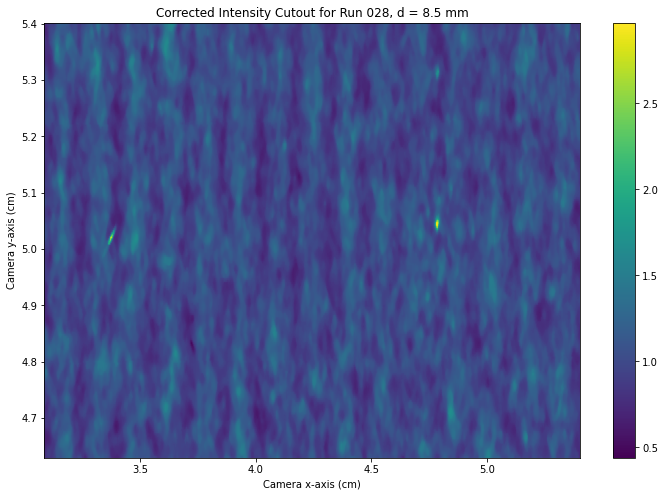

In [43]:
fig, ax1 = plt.subplots(figsize = (12,8))

# c = ax1.imshow(exp1alldata[0][3], aspect = "auto")
# ax1.add_patch(Rectangle((xstart,ystart),xend - xstart ,yend - ystart, edgecolor = "r", facecolor = 'none'))



c = ax1.imshow(filtregion[2,5], aspect = "auto", extent = np.array([xstart,xend,ystart,yend])*cm_per_pixel)

# ax1.axvline(180)
fig.colorbar(c)
ax1.set_title("Corrected Intensity Cutout for Run 028, d = 8.5 mm")
ax1.set_xlabel("Camera x-axis (cm)")
ax1.set_ylabel("Camera y-axis (cm)")

# fig.savefig("cutout.jpg")
# ax1.plot(exp1alldata[0][1][1500, :])

# ax1.set_xlim(1350,1450)
# ax1.set_ylim(1350,1450)

plt.show()

In [44]:
filtregion.shape

(6, 21, 210, 730)

In [45]:
camx, camy = np.linspace(xstart, xend, filtregion.shape[-1]) * cm_per_pixel *1e-2, np.linspace(ystart, yend, filtregion.shape[-2]) * cm_per_pixel*1e-2

exp1slice = abs(np.mean(filtregion,axis = -2))



Ldata = 8.2955
ddata = np.linspace(4.5,44.5,21)*1e-3
pdata = 3e-6



    



jpdatafitted = np.empty(exp1slice.shape)
jpdataparams = np.empty((*exp1slice.shape[:2],4))

for i in range(exp1slice.shape[0]):
    for j in range(exp1slice.shape[1]):
        profile = exp1slice[i,j]
        jpdataparams[i,j] = best_fit_moire_period(cosine_func, camx, profile, pdata,Ldata,ddata[j])
        jpdatafitted[i,j] = cosine_func(camx,*jpdataparams[i,j])


datacont = abs(jpdataparams[...,1]/jpdataparams[...,0])
datafreq = 1/(jpdataparams[...,2])


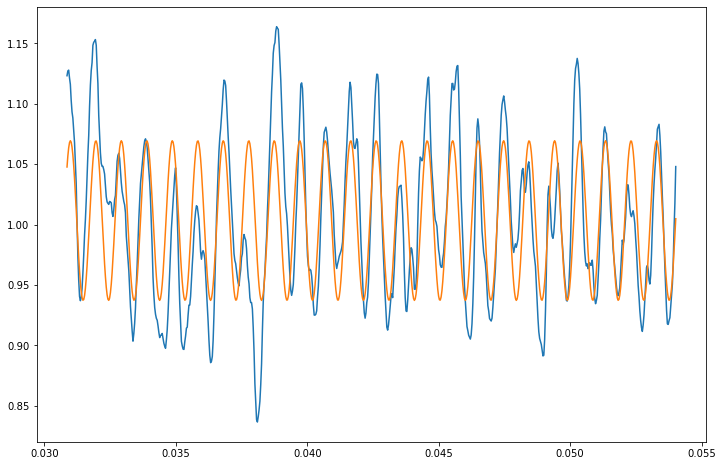

In [46]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(camx,exp1slice[0,10])
ax1.plot(camx,jpdatafitted[0,10])

plt.show()

(3, 21)
d0 (mm):  [[-1.9820134 ]
 [-2.22489886]
 [-1.68915163]]


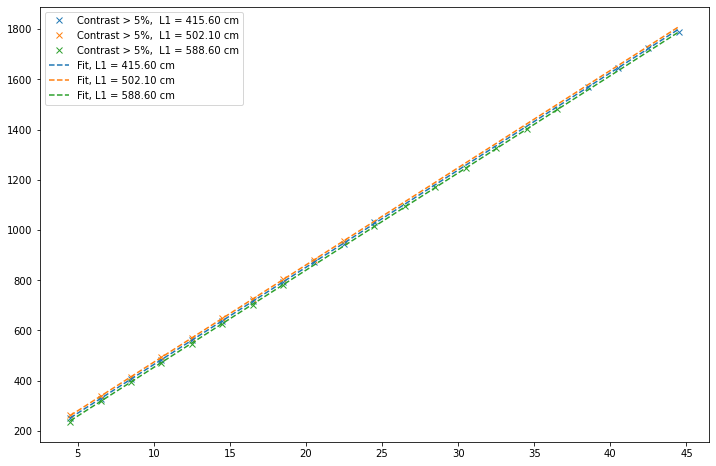

In [130]:
# def lin_func(d,d0,L0):
#     return (d - d0)/((8.2955-L0)*3e-6)

def lin_func(d,d0):
    return (d - d0)/((8.2955+0.309088)*3e-6)


def get_outlier_mask(data_arr,outlier_indices):
    mask = np.full(data_arr.shape,True)
    for i in range(data_arr.shape[0]):
        for ind in outlier_indices[i]:
            mask[i,ind] = False
    return mask

runs = [re.findall('[0-9]+', i)[0] for i in os.listdir(exp1path)]

monoindices = [runs.index(i) for i in runs if int(i) % 4 == 0]

cont5pcmaskmono = datacont[monoindices] > 5e-2
print(cont5pcmaskmono.shape)

monodatafreq = datafreq[monoindices]

# outmask = get_outlier_mask(monodatafreq,[[12],[11,17,18],[]])
# print(outmask.shape)



# monolinfitwitherr = [curve_fit(lin_func,ddata[outmask[i]], monodatafreq[i,outmask[i]], p0 = [-2e-3,10e-2], maxfev = 5000)\
#                      for i, monoind in enumerate(monoindices)]

# monolinfitparams = np.array([fit[0] for fit in monolinfitwitherr])


monolinfitwitherr = [curve_fit(lin_func,ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3], maxfev = 5000)\
                     for i, monoind in enumerate(monoindices)]

d0mono = np.array([fit[0] for fit in monolinfitwitherr])


print("d0 (mm): ", d0mono*1e3)

# print("L0 (cm): ", np.mean([monolinfitparams.T[1], polylinfitparams.T[1]])*1e2)

fig, ax1 = plt.subplots(figsize = (12,8))
# [ax1.plot(ddata*1e3,monodatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, monoind in enumerate(monoindices)]
plt.gca().set_prop_cycle(None)

# [ax1.plot(ddata[outmask[i]]*1e3,monodatafreq[i][outmask[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, monoind in enumerate(monoindices)]
[ax1.plot(ddata[cont5pcmaskmono[i]]*1e3,monodatafreq[i][cont5pcmaskmono[i]],"x", label = "Contrast > 5%%,  L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, monoind in enumerate(monoindices)]

plt.gca().set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,*monolinfitparams[i]),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, monoind in enumerate(monoindices)]

ax1.legend()
# plt.xlim(24,47)
# plt.ylim(800,1900)
plt.show()

(3, 21)
d0 (mm):  [[-1.99998834]
 [-2.2589062 ]
 [-1.68038244]]


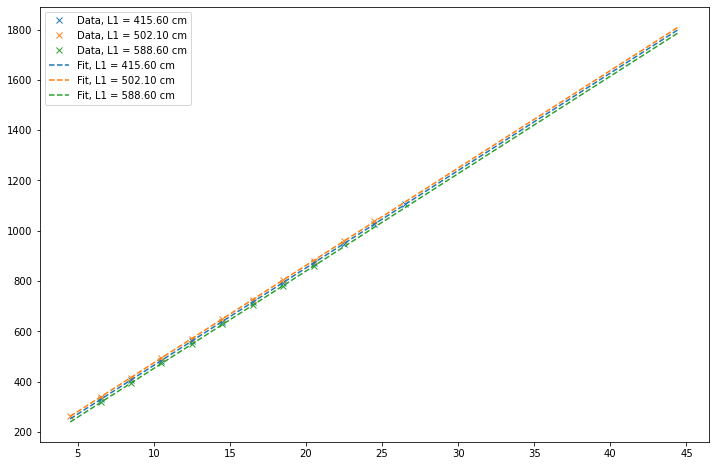

In [131]:

polyindices = [runs.index(i) for i in runs if int(i)%2 != 0]

polydatafreq = datafreq[polyindices]

outmask = get_outlier_mask(polydatafreq,[[],[],[12,13,15]])

cont5pcmaskpoly = datacont[polyindices] > 5e-2
print(cont5pcmaskpoly.shape)


# polylinfitwitherr = [curve_fit(lin_func,ddata[outmask[i]], polydatafreq[i,outmask[i]], p0 = [-2e-3,10e-2], maxfev = 5000)\
#                      for i, polyind in enumerate(polyindices)]

# polylinfitparams = np.array([fit[0] for fit in polylinfitwitherr])

polylinfitwitherr = [curve_fit(lin_func,ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3], maxfev = 5000)\
                     for i, polyind in enumerate(polyindices)]

d0poly = np.array([fit[0] for fit in polylinfitwitherr])



print("d0 (mm): ", d0poly*1e3)
# print("L0 (cm): ", np.mean(polylinfitparams.T[1])*1e2)

fig, ax1 = plt.subplots(figsize = (12,8))
# [ax1.plot(ddata*1e3,polydatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]

# [ax1.plot(ddata[outmask[i]]*1e3,polydatafreq[i][outmask[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]
[ax1.plot(ddata[cont5pcmaskpoly[i]]*1e3,polydatafreq[i][cont5pcmaskpoly[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]

plt.gca().set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,*polylinfitparams[i]),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.legend()
# plt.xlim(24,47)
# plt.ylim(800,1900)
plt.show()



### JPARC Simulations


In [132]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[::4], TOFcounts[::4]

TOF *= 1e-3
TOFcountsarea = np.trapz(TOFcounts) # area under curve
TOFcountsnormed = TOFcounts/TOFcountsarea # sum is 1

TOF = TOF[TOFcountsnormed > 2e-4]
jpplam = TOFcountsnormed[TOFcountsnormed > 2e-4]

def TOFtolambda(TOF, planck_const, mass, detector_dist):
    return TOF * planck_const / (mass * detector_dist)


m_neu = 1.6749275e-27
planck_const = 6.6261e-34
detector_dist = 24

jplam = TOFtolambda(TOF,planck_const,m_neu,detector_dist)

cutout_mask = (TOF > 30e-3) & (TOF < 36e-3)


In [53]:
print(np.sum(jpplam))


0.9990215324637974


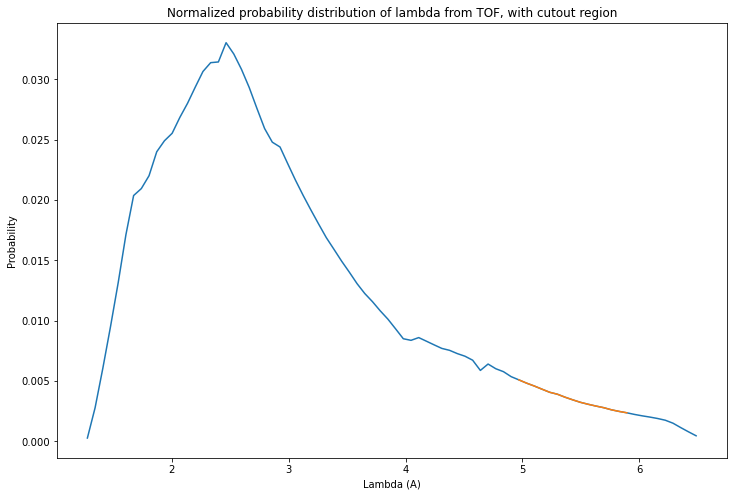

In [54]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(jplam*1e10, jpplam)
ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask])
# ax1.plot(newjplam[cutout_mask]*1e10, newTOFcountsnormed[cutout_mask])

# ax1.plot(TOF[cutout_mask],TOFcounts[cutout_mask])
# plt.xlim(4.5,6.1)
ax1.set_xlabel("Lambda (A)")
ax1.set_ylabel("Probability")
ax1.set_title("Normalized probability distribution of lambda from TOF, with cutout region")
# fig.savefig("jplamdist.jpg")
plt.show()

In [55]:
print(TOF[cutout_mask][0]*1e3, TOF[cutout_mask][-1]*1e3)

30.15 35.75000000000001


In [540]:
Nbc = 5e28*4.149e-15
mt = 5
x0 = 0

pjp = 3e-6
xbinjp = 1e-6
ybinjp = 1e-6

jpmonolam = jplam[cutout_mask]
jpmonoplam = jpplam[cutout_mask]


hjp = 8.53e-6
jpd = np.linspace(4.5,44.5,21)*1e-3 


L0mono = -30.9088*1e-2


L1jp = (96.6 + 319)*1e-2 +  np.arange(0,3,1) * 0.865 - L0mono




jpd,L1jp = force_broadcast(jpd,L1jp)


L1jp = L1jp - (jpd - jpd[0])/2

Ljp = 8.2955 - L0mono




monophijp = Nbc*jpmonolam*hjp



jpcamsize = 1e-2
jpslit = 200e-6
jpslits = np.linspace(200,400,3)*1e-6

# print(jpslit)
jpres = 100e-6

jpd, L1jp = force_broadcast(jpd,L1jp)


G1monosd = {"p":pjp, "L1": L1jp, "phi":monophijp}
G1monosd["L2"] = jpd


G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
G2monosd["L2"] = Ljp - G2monosd["L1"]
print(G2monosd["L2"])

Ioff = np.linspace(500,500,1)

simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}

# simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":Ljp,"d":G1monosd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
#              "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, \
#                  "slity" : jpslit, "res": jpres, "batches": 500 }

simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":np.array([Ljp]),"d":G1monosd["L2"],"mt":mt, \
                 "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
                 "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
                 "convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 500, "Ioffset": Ioff }



[[8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]
 [8.2955 8.2955 8.2955]]


In [224]:
print(L1jp)

[[4.465088 5.330088 6.195088]]


In [209]:
contjpmonoslit = []
fitparamsjpmonoslit = []

In [210]:
# t0 = time()

# simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
# simjpmono.propagate_to("G1")
# simjpmono.propagate_to("G2")
# simjpmono.generate_after("G2")

for slit in jpslits:
    t0 = time()
    simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}

    simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":Ljp,"d":G1monosd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,\
                     "xbin":xbinjp,"y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
                     "convmode" : "valid", "slity" : jpslit, "res": jpres, "batches": 500, "Ioffset": Ioff }
    simjpmonoinit["slitx"] = slit
    simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
    simjpmono.propagate_to("G1")
    simjpmono.propagate_to("G2")
    simjpmono.generate_after("G2")
    contjpmonoslit.append(simjpmono.get_value("contrast"))
    fitparamsjpmonoslit.append(simjpmono.get_value("fitparams"))

    print(time() - t0, "seconds")
    
# print(time() - t0, "seconds")

0.00019999999999999998
(51, 3) (51, 1) (15, 11) (15, 11) (15,)
(51, 3, 1, 1) (51, 1, 1, 1) (1, 1, 15, 11) (1, 1, 15, 11) (1, 1, 15, 1)
(51, 3) (51, 3) (51, 3, 15, 121) (51, 3, 15, 121) (15,)
(51, 3, 1, 1) (51, 3, 1, 1) (51, 3, 15, 121) (51, 3, 15, 121) (1, 1, 15, 1)
(500, 51, 3, 15, 20) after parallel
(51, 3, 15, 10000) after reshape
(51, 3, 10000) before convolution
Finding contrast
134.95816159248352 seconds
0.0003
(51, 3) (51, 1) (15, 11) (15, 11) (15,)
(51, 3, 1, 1) (51, 1, 1, 1) (1, 1, 15, 11) (1, 1, 15, 11) (1, 1, 15, 1)
(51, 3) (51, 3) (51, 3, 15, 121) (51, 3, 15, 121) (15,)
(51, 3, 1, 1) (51, 3, 1, 1) (51, 3, 15, 121) (51, 3, 15, 121) (1, 1, 15, 1)
(500, 51, 3, 15, 20) after parallel
(51, 3, 15, 10000) after reshape
(51, 3, 10000) before convolution
Finding contrast
140.8861608505249 seconds
0.00039999999999999996
(51, 3) (51, 1) (15, 11) (15, 11) (15,)
(51, 3, 1, 1) (51, 1, 1, 1) (1, 1, 15, 11) (1, 1, 15, 11) (1, 1, 15, 1)
(51, 3) (51, 3) (51, 3, 15, 121) (51, 3, 15, 121) (15,

In [167]:
Ijpmono = simjpmono.get_value("intensity")
rawjpmono = simjpmono.get_value("raw")
contjpmono = simjpmono.get_value("contrast")
fitparamsjpmono = simjpmono.get_value("fitparams")
simfreqmono = 1/(fitparamsjpmono[...,2]) 


1 2


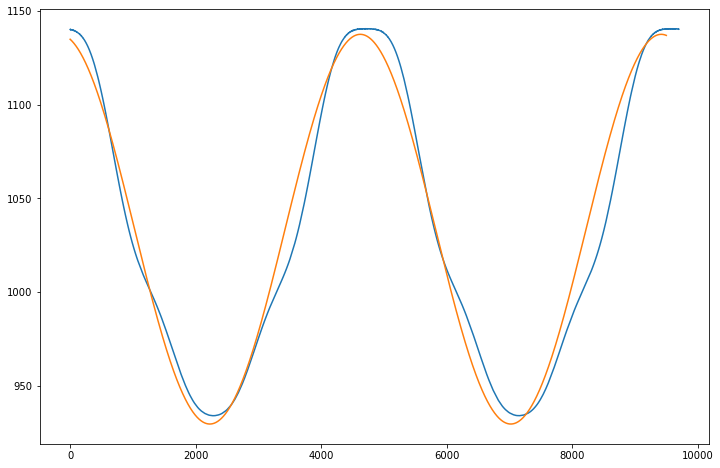

KeyboardInterrupt: 

In [732]:
indtup = (0,2)
for i in range(fitparamsjpmono.shape[0]):
    for j in range(fitparamsjpmono.shape[1]):
        fig, ax1 = plt.subplots(figsize = (12,8))
        clear_output(wait= True)

        ax1.plot(Ijpmono[i,j])
        ax1.plot(cosine_func(simjpmono.x, *fitparamsjpmono[i,j]))
        print(i,j)
        plt.pause(0.5)
        ax1.cla()
        plt.show()
# ax1.plot(Ijpmono[indtup])
# ax1.plot(cosine_func(simjpmono.x, *fitparamsjpmono[indtup]))



In [ ]:
print(contjpmono.shape)

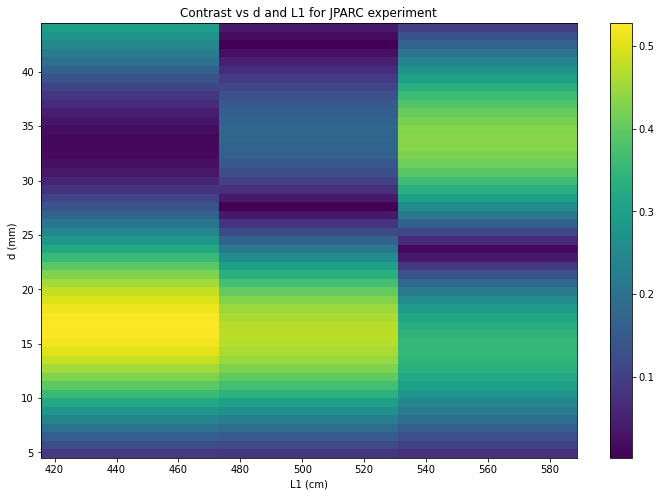

In [267]:
fig, ax1 = plt.subplots(figsize = (12,8))

c = ax1.imshow(contjpmono, aspect = "auto", origin = "lower",extent = (L1jp.squeeze()[0]*1e2,L1jp.squeeze()[-1]*1e2,jpd.squeeze()[0]*1e3,jpd.squeeze()[-1]*1e3))



# c = ax1.imshow(Ijp, extent = (simjp.x[0]*1e3, simjp.x[-1]*1e3, simjp.y[0]*1e3, simjp.y[-1]*1e3), origin = "lower")

# c = ax1.imshow(Ijp[0], extent = (simjp.x[0]*1e3, simjp.x[-1]*1e3, simjp.y[0]*1e3, simjp.y[-1]*1e3), origin = "lower")
fig.colorbar(c)

ax1.set_xlabel("L1 (cm)")
ax1.set_ylabel("d (mm)")
ax1.set_title("Contrast vs d and L1 for JPARC experiment")
# fig.savefig("contjpL1d.jpg")
plt.show()

In [299]:
Nbc = 5e28*4.149e-15


jppolylam = jplam.copy()
jppolyplam = jpplam.copy()


polyphijp = Nbc*jppolylam*hjp





G1polysd = {"p":pjp, "L1": L1jp, "phi":polyphijp}
G1polysd["L2"] = jpd


G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
G2polysd["L2"] = Ljp - G2polysd["L1"]


Ioff = np.linspace(4000,5000,4)



simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}
# simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
#              "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
#              "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 5000 }
simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
             "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
             "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 5000, "Ioffset" : Ioff }


In [300]:
t0 = time()
simjppoly = PGMI(simjppolyapts,simjppolyinit)
simjppoly.propagate_to("G1")
simjppoly.propagate_to("G2")
simjppoly.generate_after("G2")


print(time() - t0, "seconds")

(5000, 51, 3, 80, 2) after parallel
(51, 3, 80, 10000) after reshape
(51, 3, 10000) before convolution
Finding contrast
(4, 1, 1) (1, 51, 3)
535.4196138381958 seconds


In [ ]:
Ijppoly = simjppoly.get_value("intensity")
rawjppoly = simjppoly.get_value("raw")
contjppoly = simjppoly.get_value("contrast")
fitparamsjppoly = simjppoly.get_value("fitparams")
simfreqpoly = 1/(fitparamsjppoly[...,2]) 


In [217]:
contjpmonoslit, fitparamsjpmonoslit = np.array([contjpmonoslit]).squeeze(), np.array([fitparamsjpmonoslit]).squeeze()

In [218]:
d0mono.shape

(3, 1)

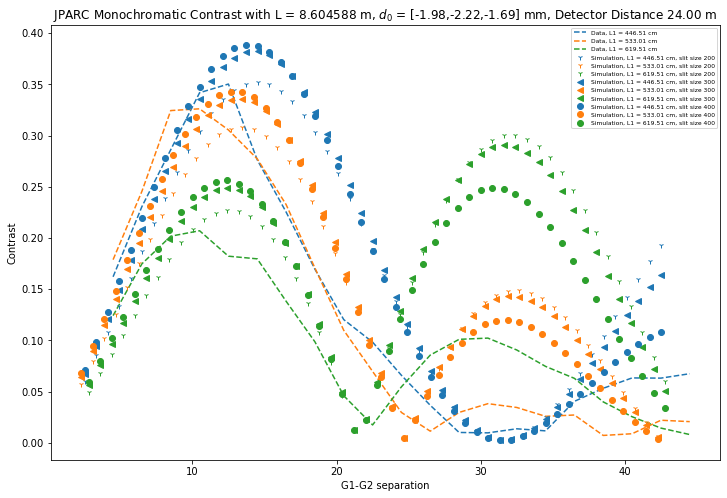

In [222]:
fig, ax1 = plt.subplots(figsize = (12,8))

slitmarkers = ["1","<","o","v","p","h","+"]




for i, monoind in enumerate(monoindices):
    ax1.plot(ddata*1e3, datacont[monoind], "--", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2) )
#     ax1.plot(ddata[cont5pcmaskmono[i]]*1e3, datacont[monoind][cont5pcmaskmono[i]], "o-", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2) )

plt.gca().set_prop_cycle(None)

for slitind, slit in enumerate(jpslits):
    for i, monoind in enumerate(monoindices):
#         if slitind == 5:
            ax1.plot((jpd[:] + d0mono[i,:])*1e3, contjpmonoslit[slitind,:,i], slitmarkers[slitind], \
                 label = "Simulation, L1 = %.2f cm, slit size %.f" % (L1jp.squeeze()[i] * 1e2, slit*1e6))
    plt.gca().set_prop_cycle(None)

# for i, monoind in enumerate(monoindices):
#     ax1.plot((jpd + d0mono[i])*1e3, contjpmono[:,i], label = "Simulation, L1 = %.2f cm, slit size %.f" % (L1jp.squeeze()[i] * 1e2, jpslit*1e6))


ax1.set_title(r"JPARC Monochromatic Contrast with L = %f m, $d_0$ = [%.2f,%.2f,%.2f] mm, Detector Distance %.2f m" % (Ljp, *(d0mono*1e3), detector_dist))
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend(prop = {"size":6})
# fig.savefig("jparcmonocontL0d0slits.jpg")
plt.show()

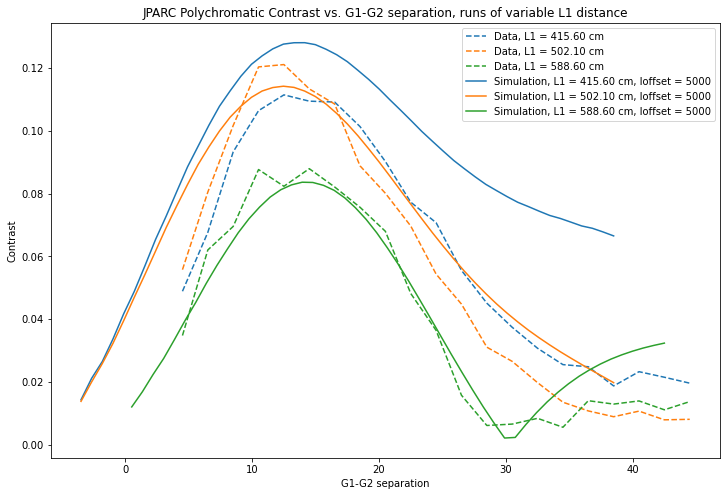

In [319]:
fig, ax1 = plt.subplots(figsize = (12,8))


d0 = -2e-3



for i, polyind in enumerate(polyindices):
    ax1.plot(ddata*1e3, datacont[polyind], "--", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2) )
    
plt.gca().set_prop_cycle(None)
for off_ind in range(len(Ioff))[-1:]:
    for i, polyind in enumerate(polyindices):
        ax1.plot((jpd+ (2*d0 if i > 1 else 4*d0))*1e3, contjppoly[off_ind,:,i], label = "Simulation, L1 = %.2f cm, Ioffset = %.f" % (L1jp.squeeze()[i] * 1e2, Ioff[off_ind]))
#         ax1.plot((jpd+ d0)*1e3, contjppoly[off_ind,:,i], label = "Simulation, L1 = %.2f cm, Ioffset = %.f" % (L1jp.squeeze()[i] * 1e2, Ioff[off_ind]))

# ax1.axvline(12.5, label = "Predicted maximum")
ax1.set_title("JPARC Polychromatic Contrast vs. G1-G2 separation, runs of variable L1 distance")
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend()
# fig.savefig("jparcpolycont.jpg")
plt.show()

In [191]:
print(d0mono)

[[-0.00198201]
 [-0.0022249 ]
 [-0.00168915]]


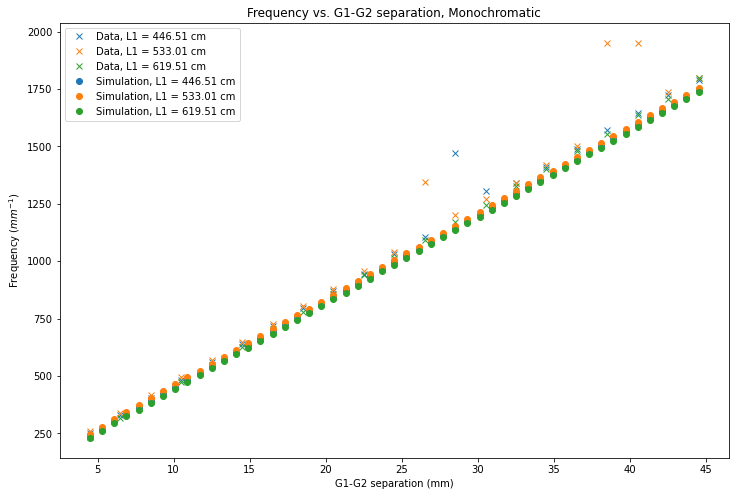

In [194]:
fig, ax1 = plt.subplots(figsize = (12,8))

# d0 = 0 



[ax1.plot(ddata*1e3,datafreq[monoind,:],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, monoind in enumerate(monoindices)]
plt.gca().set_prop_cycle(None)

[ax1.plot(jpd.squeeze()*1e3 - d0mono[i],simfreqmono[:,i]*(1 - (d0mono[i]/jpd).squeeze()),"o", label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2))\
 for i, monoind in enumerate(monoindices)]

# simfreqmonoslit = 1/fitparamsjpmonoslit[...,2]
# for slitind, slit in enumerate(jpslits):
#     for i, monoind in enumerate(monoindices):
#         if slitind == 5:
#             ax1.plot((jpd[:,i] + d0mono[:,i])*1e3, simfreqmonoslit[slitind,:,i]*(1 - (d0mono[:,i]/jpd[:,i]).squeeze()), slitmarkers[slitind], \
#                  label = "Simulation, L1 = %.2f cm, slit size %.f" % (L1jp.squeeze()[i] * 1e2, slit*1e6))
#     plt.gca().set_prop_cycle(None)


ax1.set_title(r"Frequency vs. G1-G2 separation, Monochromatic")
ax1.set_xlabel("G1-G2 separation (mm)")
ax1.set_ylabel(r"Frequency $(mm^{-1})$")
# ax1.text(20,1.2,"$R^2 = %.2f$" % r2)
ax1.legend()

# fig.savefig("monofreqvsdjpL0d0.jpg")

plt.show()

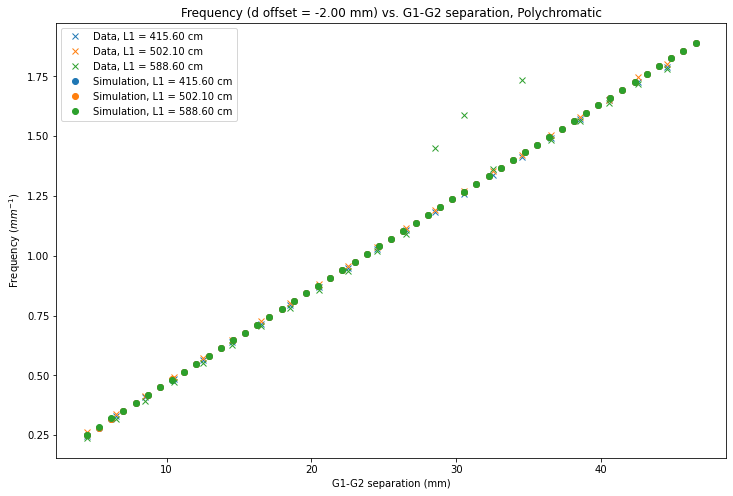

In [367]:
fig, ax1 = plt.subplots(figsize = (12,8))


simfreqpoly = 1/(fitparamsjppoly*1e3) 

# r2 = [r2_score(datafreq[i,:,2],simfreq[:,i,2]) for i in range(fitparamsjp.shape[1])]
[ax1.plot(ddata*1e3,datafreq[polyind,:,2],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]
plt.gca().set_prop_cycle(None)

[ax1.plot(jpd.squeeze()*1e3,simfreqpoly[:,i,2]*(1 - d0/jpd.squeeze()),"o", label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i in range(fitparamsjppoly.shape[1])]



ax1.set_title(r"Frequency (d offset = %.2f mm) vs. G1-G2 separation, Polychromatic" % (d0*1e3))
ax1.set_xlabel("G1-G2 separation (mm)")
ax1.set_ylabel(r"Frequency $(mm^{-1})$")
# ax1.text(20,1.2,"$R^2 = %.2f$" % r2)
ax1.legend()

fig.savefig("polyfreqvsdjp.jpg")

plt.show()